In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
# Helper functions for creating weight variables
def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

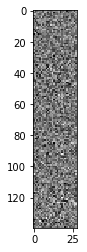

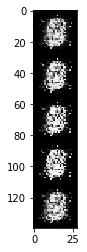

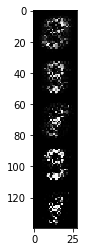

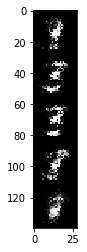

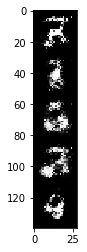

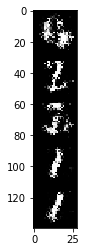

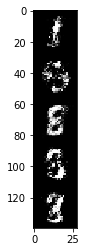

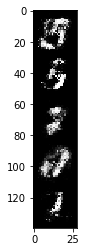

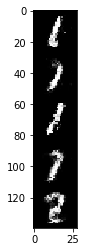

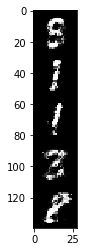

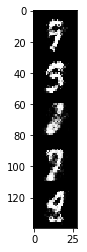

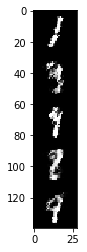

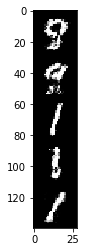

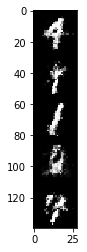

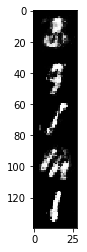

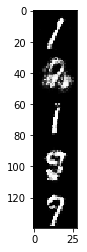

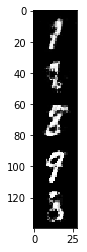

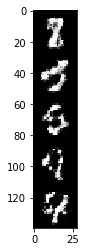

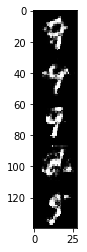

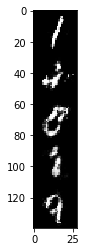

In [4]:
tf.reset_default_graph()

def fully_connected_layer(in_tensor, in_units, out_units, activation=tf.nn.relu):
    """
    Add a fully connected layer to the default graph, taking as input `in_tensor`, and
    creating a hidden layer of `out_units` neurons. This should be called within a unique variable
    scope. Creates variables W and b, and computes activation_function(in * W + b).
    """
    W = tf.get_variable("weights", [in_units, out_units], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b = tf.get_variable("biases", [out_units], initializer=tf.constant_initializer(0.1))
    return activation(tf.matmul(in_tensor, W) + b)

def variables_from_scope(scope_name):
    """
    Returns a list of all variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope_name)

def generator(noise):
    #TODO: implement MLP outputting an image
    with tf.variable_scope("fc1"):
        h1 = fully_connected_layer(noise, 100, 128)
    with tf.variable_scope("fc2"):
        h2 = fully_connected_layer(h1, 128, 784, activation=tf.sigmoid)
    return h2

def discriminator(images):
    #TODO: implement MLP outputting a classification (real or fake)
    with tf.variable_scope("fc1"):
        h1 = fully_connected_layer(images, 784, 128)
    with tf.variable_scope("fc2"):
        h2 = fully_connected_layer(h1, 128, 1, activation=tf.sigmoid)
    return h2

def visualize_row(images, img_width=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a column
    in a plot, using `cmap` to map from numbers to colors.
    """
    im = np.reshape(images, [-1, img_width])
    plt.figure()
    plt.imshow(im, cmap=cmap)
    plt.show()
    
def build_gan():
    random_noise = tf.placeholder(tf.float32, [None, 100])
    
    with tf.variable_scope("generator"):   #in this scope, variable has prefix eg. generator/w1
        fake_images = generator(random_noise)
    
    real_images = tf.placeholder(tf.float32, [None, 784])
    
    with tf.variable_scope("discriminator") as scope:
        disc_on_real = discriminator(real_images)
        scope.reuse_variables()
        disc_on_fake = discriminator(fake_images)
    
    #Compute how well our generator and our discriminator did for this batch
    g_loss = -tf.reduce_mean(tf.log(disc_on_fake))
    d_loss = -tf.reduce_mean(tf.log(disc_on_real) + tf.log(1. - disc_on_fake))
    
    #Optimize
    optimize_g = tf.train.AdamOptimizer().minimize(g_loss, var_list=variables_from_scope("generator"))  #var_list, only update the variable in var_list
    optimize_d = tf.train.AdamOptimizer().minimize(d_loss, var_list=variables_from_scope("discriminator"))
    
    return {
        'random_noise': random_noise,
        'real_images': real_images,
        'fake_images': fake_images,
        'optimize_g': optimize_g,
        'optimize_d': optimize_d
    }

model = build_gan()
initialize_all = tf.global_variables_initializer()

def next_feed_dict():
    return{
        model['random_noise']: np.random.uniform(-1.0, 1.0, [50, 100]),
        model['real_images']: mnist.train.next_batch(50)[0]
    }

with tf.Session() as sess:
    sess.run(initialize_all)
    for i in range(20000):
        sess.run(model['optimize_d'], feed_dict=next_feed_dict())
        sess.run(model['optimize_g'], feed_dict=next_feed_dict())
        if i % 1000 == 0:
            images = sess.run(model['fake_images'], feed_dict=next_feed_dict())
            visualize_row(images[:5])